# LB06: Знакомство за обработкой естественного языка

<div style="text-align: right"> ПСА 5 (Введение в машинное обучение). Мехмат, БГУ</div>
    
<div style="text-align: right"> Тишуров Алексей, ноябрь 2021 </div>

<div style="text-align: right"> Выполнил студент 3 курса 5 группы ММФ БГУ </div>

<div style="text-align: right"> Кирилло Дмитрий </div>

Данный материал использует лицензию [Creative Commons CC BY-NC-SA 4.0.](https://creativecommons.org/licenses/by-nc-sa/4.0/) со всеми вытекающими. На прилагаемый к материалу датасет лицензия не распространяется. 

Базовая оценка за работу - 8. Одно дополнительное задание превратит ее в 9. А еще одно в 10.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

В этой лабораторной работе вы будете знакомиться с NLP на примере задаче по определению "неискренних" вопросов на quora. По этой ссылке можно ознакомиться с задачей и данными https://www.kaggle.com/c/quora-insincere-questions-classification. Самое важное копирую сюда:

In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

    Has a non-neutral tone
        Has an exaggerated tone to underscore a point about a group of people
        Is rhetorical and meant to imply a statement about a group of people
    Is disparaging or inflammatory
        Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
        Makes disparaging attacks/insults against a specific person or group of people
        Based on an outlandish premise about a group of people
        Disparages against a characteristic that is not fixable and not measurable 
    Isn't grounded in reality
        Based on false information, or contains absurd assumptions
    Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

Датасет нужно скачивать со страницы https://www.kaggle.com/c/quora-insincere-questions-classification/data (нужно будет зарегистрироваться и принять правила соревнования)

In [5]:
df = pd.read_csv('train.csv')
#df = pd.read_csv('train.csv', skiprows=lambda row: row % 5 > 0)

In [3]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
df_copy = df.copy()
df_copy.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


ВНИМАНИЕ! Если ваш компьютер будет считать слишком долго на полном датасете, то загружайте вторым способом. skiprows=lambda row: row % 5 > 0 означает, что будет прочитана только каждая пятая строка.

Либо используйте kaggle kernels или google colaboratory

# Часть 0. Ваше впечатление от датасета

Сделайте аналитику на ваш выбор. Во время выполнения следующих заданий вам может прийти в голову специфичная аналитика связанная именно с текстами. Не стесняйтесь ее релазировать и продемонстрировать.

Посмотрите на распределение целевой переменной, почитайте тексты, для которых она равна 1. Сделайте выводы.

#### <i> Типы признаков в данных </i>

In [5]:
df.dtypes

qid              object
question_text    object
target            int64
dtype: object

In [6]:
df.shape

(1306122, 3)

#### <i> Пропуски данных </i>

In [7]:
df.isnull().values.any() 

False

In [8]:
df.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

#### <i> Есть ли какие-то явные взаимосвязи между признаками? </i>

In [9]:
df.corr()

,target
target,1.0


#### <i> Распределения признаков и присутствие/отсутствие явных выбросов </i>

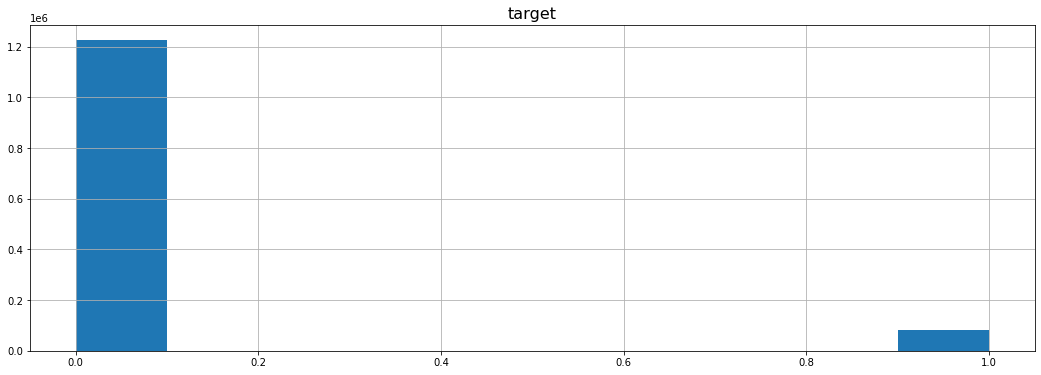

In [10]:
fig = plt.figure(figsize=(18,6))
df['target'].hist()
plt.title(f'target', fontsize=16)
plt.show()

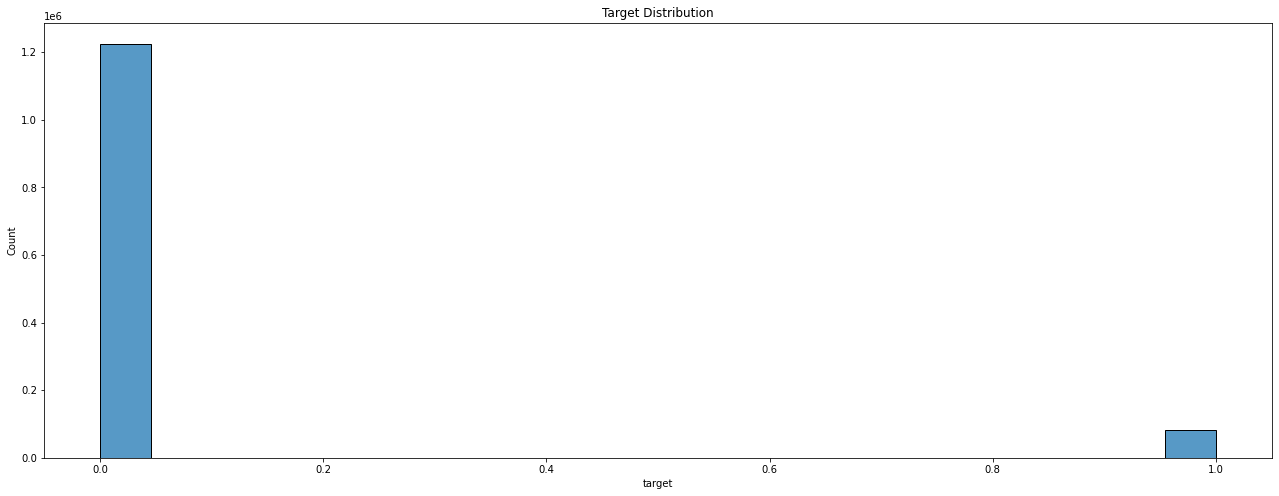

In [11]:
plt.figure(figsize=(22, 8))
plt.title('Target Distribution')
sns.histplot(df, x='target')
plt.show()

In [12]:
true_class_weight = df['target'].mean()
true_class_weight

0.06187017751787352

Как можно заметить, соотношение классов очень несбалансированное

In [13]:
text_question = df.loc[df['target'] == 1, 'question_text']
text_question

22         Has the United States become the largest dicta...
30         Which babies are more sweeter to their parents...
110        If blacks support school choice and mandatory ...
114        I am gay boy and I love my cousin (boy). He is...
115                     Which races have the smallest penis?
                                 ...                        
1306093    How is it to have intimate relation with your ...
1306094    Why is it when singers have lyrics about voice...
1306099                    Do pakis smell of curry and shit?
1306103    Isn't Trump right after all? Why should the US...
1306112                  Are you ashamed of being an Indian?
Name: question_text, Length: 80810, dtype: object

In [14]:
text_question.count()

80810

In [15]:
text_question = text_question.to_numpy()

In [16]:
df[df["question_text"].str.lower().str.endswith("!", na = False)]

,qid,question_text,target
1816,005a568d1ca345707448,How is YouTuber Debasree Banerjee getting away...,0
2390,0077f50514fdb490710e,How can I stop feeling so insecure about my re...,0
5852,0121d0988c60db7c3691,How do I get more pageviews on my blog? Help!,0
9014,01c29ff9fa85107895b1,Will I fail 5th grade? I got only Fs and there...,0
11138,023096ea20d4b15fb370,What stylictic device and where is it used her...,0
...,...,...,...
1293633,fd8a27d299c222292a5a,"I'm new to Quora, so my question is general in...",0
1296396,fe153cb745740832ecf4,How can we bring a family member or friends ba...,0
1297387,fe468486dae82bb19341,"How can I travel to imphal, Manipur by train? ...",0
1300039,fecc8eaec7766f371cf0,What is the best testosterone supplement for a...,0


# Часть 1. Tf-Idf

В этой части необходимо пройти классический путь решения задачи методом "мешок слов". Ваша задача:
1. Нормализовать данные (если нужно)
2. Выбрать вариант токенизации (начните с from nltk import word_tokenize и подумайте, достаточно ли его). Либо с помощью https://spacy.io/api/tokenizer/, если кажется, что нужно что-то большее.
3. Определитесь со списком стоп-слов.
4. Постройте конвейер (Pipeline), включающий в себя превращение текстов в векторы и непосредственно моделирование с помощью линейной модели.
5. Объясните предсказания вашей модели при помощи eli5.
5. Попробуйте подобрать лучшие параметры при помощи GridSearchCV или RandomizedSearchCV. Второй вариант НАМНОГО лучше, как вы уже успели убедиться в прошлом. Кроме того, тут вам нужно будет подбирать как параметры самой модели, так и параметры векторизатора (min_df и т.д.).
6. Попробуйте как можно сильнее сжать пространство признаков путем фильтрации редких слов, при этом старайтесь не потерять в качестве.

Ниже по пунктам подробнее. Не надо волноваться, если сразу что-то будет не получаться. Все ваши вопросы (в том числе и по kaggle) я ожидаю в канале в slack или в личке. 

In [7]:
#загрузка дополнительных данных для nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Задание 1.1 Нормализация и токенизация

Стоит быть честным и сказать, что тексты вопросов написаны очень хорошо, без шума, разделены в основном пробелами. Поэтому эта часть тривиальна. Поэтому, просто пощупайте и сравните 2 токенизатора.

In [8]:
from nltk.tokenize import word_tokenize

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
sklearn_tokenizer = vect.build_tokenizer()

In [20]:
print('\n'.join([str(word_tokenize(text)) for text in text_question[:10]]))

['Has', 'the', 'United', 'States', 'become', 'the', 'largest', 'dictatorship', 'in', 'the', 'world', '?']
['Which', 'babies', 'are', 'more', 'sweeter', 'to', 'their', 'parents', '?', 'Dark', 'skin', 'babies', 'or', 'light', 'skin', 'babies', '?']
['If', 'blacks', 'support', 'school', 'choice', 'and', 'mandatory', 'sentencing', 'for', 'criminals', 'why', 'do', "n't", 'they', 'vote', 'Republican', '?']
['I', 'am', 'gay', 'boy', 'and', 'I', 'love', 'my', 'cousin', '(', 'boy', ')', '.', 'He', 'is', 'sexy', ',', 'but', 'I', 'dont', 'know', 'what', 'to', 'do', '.', 'He', 'is', 'hot', ',', 'and', 'I', 'want', 'to', 'see', 'his', 'di', '*', '*', '.', 'What', 'should', 'I', 'do', '?']
['Which', 'races', 'have', 'the', 'smallest', 'penis', '?']
['Why', 'do', 'females', 'find', 'penises', 'ugly', '?']
['How', 'do', 'I', 'marry', 'an', 'American', 'woman', 'for', 'a', 'Green', 'Card', '?', 'How', 'much', 'do', 'they', 'charge', '?']
['Why', 'do', 'Europeans', 'say', 'they', "'re", 'the', 'superior

In [21]:
print('\n'.join([str(sklearn_tokenizer(text)) for text in text_question[:10]]))

['Has', 'the', 'United', 'States', 'become', 'the', 'largest', 'dictatorship', 'in', 'the', 'world']
['Which', 'babies', 'are', 'more', 'sweeter', 'to', 'their', 'parents', 'Dark', 'skin', 'babies', 'or', 'light', 'skin', 'babies']
['If', 'blacks', 'support', 'school', 'choice', 'and', 'mandatory', 'sentencing', 'for', 'criminals', 'why', 'don', 'they', 'vote', 'Republican']
['am', 'gay', 'boy', 'and', 'love', 'my', 'cousin', 'boy', 'He', 'is', 'sexy', 'but', 'dont', 'know', 'what', 'to', 'do', 'He', 'is', 'hot', 'and', 'want', 'to', 'see', 'his', 'di', 'What', 'should', 'do']
['Which', 'races', 'have', 'the', 'smallest', 'penis']
['Why', 'do', 'females', 'find', 'penises', 'ugly']
['How', 'do', 'marry', 'an', 'American', 'woman', 'for', 'Green', 'Card', 'How', 'much', 'do', 'they', 'charge']
['Why', 'do', 'Europeans', 'say', 'they', 're', 'the', 'superior', 'race', 'when', 'in', 'fact', 'it', 'took', 'them', 'over', '000', 'years', 'until', 'mid', '19th', 'century', 'to', 'surpass', '

Как можно заметить, что nltk-токенизатор оставляет знаки препинания в предложениях, что в некоторых задачах весьма полезно, если нужно знать оттенок фразы

# Часть 1.2 Стоп-слова

ВНИМАНИЕ! ВНИМАТЕЛЬНО ЧИТАЙТЕ, ЧТО НУЖНО СДЕЛАТЬ В РАМКАХ ЗАДАНИЯ.

Токенизация должна быть согласована со стоп-словами. Т.е. токенизатор должен воспринимать стоп-слова как токены, а не как несколько токенов (не разбивать на несколько и не фильтровать). В этом задании вам нужно посмотреть на стоп-слова из nltk и проверить, являются ли два токенизатора выше согласованными со списком английских стоп-слов из nltk. Для этого попробуйте токенизировать по очереди все стоп-слова двумя текенизаторами и сделайте соответствующие выводы.

Стоп-слова – это слова, которые выкидываются из текста до/после обработки текста. Когда мы применяем машинное обучение к текстам, такие слова могут добавить много шума, поэтому необходимо избавляться от нерелевантных слов.

Стоп-слова это обычно понимают артикли, междометия, союзы и т.д., которые не несут смысловой нагрузки. При этом надо понимать, что не существует универсального списка стоп-слов, все зависит от конкретного случая.

В NLTK есть предустановленный список стоп-слов. Перед первым использованием нам понадобится его скачать: nltk.download(“stopwords”). После скачивания можно импортировать пакет stopwords и посмотреть на сами слова

Мы конвертировали список во множество. Множество это абстрактный тип данных, который может хранить уникальные значения, в неопределенном порядке. Поиск по множеству гораздо быстрее поиска по списку. Для небольшого количества слов это не имеет значения, но если речь про большое количество слов, то строго рекомендуется использовать множества.

In [10]:
from nltk.corpus import stopwords

In [37]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [38]:
[(word_tokenize(text), text) for text in stopwords.words('english')]

[(['i'], 'i'),
 (['me'], 'me'),
 (['my'], 'my'),
 (['myself'], 'myself'),
 (['we'], 'we'),
 (['our'], 'our'),
 (['ours'], 'ours'),
 (['ourselves'], 'ourselves'),
 (['you'], 'you'),
 (['you', "'re"], "you're"),
 (['you', "'ve"], "you've"),
 (['you', "'ll"], "you'll"),
 (['you', "'d"], "you'd"),
 (['your'], 'your'),
 (['yours'], 'yours'),
 (['yourself'], 'yourself'),
 (['yourselves'], 'yourselves'),
 (['he'], 'he'),
 (['him'], 'him'),
 (['his'], 'his'),
 (['himself'], 'himself'),
 (['she'], 'she'),
 (['she', "'s"], "she's"),
 (['her'], 'her'),
 (['hers'], 'hers'),
 (['herself'], 'herself'),
 (['it'], 'it'),
 (['it', "'s"], "it's"),
 (['its'], 'its'),
 (['itself'], 'itself'),
 (['they'], 'they'),
 (['them'], 'them'),
 (['their'], 'their'),
 (['theirs'], 'theirs'),
 (['themselves'], 'themselves'),
 (['what'], 'what'),
 (['which'], 'which'),
 (['who'], 'who'),
 (['whom'], 'whom'),
 (['this'], 'this'),
 (['that'], 'that'),
 (['that', "'ll"], "that'll"),
 (['these'], 'these'),
 (['those'], 't

In [39]:
[(sklearn_tokenizer(text), text) for text in stopwords.words('english')]

[([], 'i'),
 (['me'], 'me'),
 (['my'], 'my'),
 (['myself'], 'myself'),
 (['we'], 'we'),
 (['our'], 'our'),
 (['ours'], 'ours'),
 (['ourselves'], 'ourselves'),
 (['you'], 'you'),
 (['you', 're'], "you're"),
 (['you', 've'], "you've"),
 (['you', 'll'], "you'll"),
 (['you'], "you'd"),
 (['your'], 'your'),
 (['yours'], 'yours'),
 (['yourself'], 'yourself'),
 (['yourselves'], 'yourselves'),
 (['he'], 'he'),
 (['him'], 'him'),
 (['his'], 'his'),
 (['himself'], 'himself'),
 (['she'], 'she'),
 (['she'], "she's"),
 (['her'], 'her'),
 (['hers'], 'hers'),
 (['herself'], 'herself'),
 (['it'], 'it'),
 (['it'], "it's"),
 (['its'], 'its'),
 (['itself'], 'itself'),
 (['they'], 'they'),
 (['them'], 'them'),
 (['their'], 'their'),
 (['theirs'], 'theirs'),
 (['themselves'], 'themselves'),
 (['what'], 'what'),
 (['which'], 'which'),
 (['who'], 'who'),
 (['whom'], 'whom'),
 (['this'], 'this'),
 (['that'], 'that'),
 (['that', 'll'], "that'll"),
 (['these'], 'these'),
 (['those'], 'those'),
 (['am'], 'am'),


Как можно заметить, оба токенизатора воспринимают стоп-слова как несколько отдельных токенов. Это, вероятно, не такая большая проблема, так как множество стоп-слов содержит и их разбитие на токены, что позволит выбросить неважные токены из данных.

# Часть 1.3 Pipeline и процесс обучения

Когда в процессе моделирования есть несколько шагов, их бывает удобно объединить в конвейер. В sklearn это реализовано в классе Pipeline. Ниже вам представлен пример его использования.
Также в этой лабе мы будем пользоваться cross_val_predict, чтобы считать честные предсказанные вероятности. Для этого указан параметр method='predict_proba' в примере внизу. Как вы можете видеть, векторизатор и классификатор остались с параметрами по умолчанию. Ваша цель - **выбрать для них нормальные параметры и полностью разбираться в том, что они значат** на основе знаний, которые вы получили на всех прошлых занятиях. На практике у вас обязательно будут спрашивать про эти параметры, а также про то, как работает TfIdfVectorizer и SGDClassifier. Типичные вопросы, ответы на которые необходимо знать для хорошей оценки:
1. Что такое стохастический градиентный спуск?
2. Как обучается и делает предсказания логистическая регрессия?
3. Что такое tf-idf и зачем это нужно?
4. Что такое кросс-валидация? Как производится кросс-валидация классом StratifiedKFold?

И, конечно же, многие другие вопросы. Аналогичные вопросы будут и к другим пунктам лабы.



Поиск по сетке можно рассматривать как исчерпывающий поиск для выбора модели.
В GridSearchCV, исходя из данных, создается сетка значений гиперпараметров и для каждой комбинации обучается модель и оценивается данные тестирования.
В этом подходе проверяется каждая комбинация значений гиперпараметров, что может быть очень неэффективным.
Например, поиск 20 различных значений параметров для каждого из 4 параметров потребует 160 000 попыток перекрестной проверки. 
Это соответствует 1 600 000 подгонок модели и 1 600 000 прогнозов, если используется 10-кратная перекрестная проверка. 
Это чрезвычайно затратно как по вычислительной мощности, так и по времени.
Напротив, RandomizedSearchCV создает сетку значений гиперпараметров и выбирает случайные комбинации для обучения модели и оценки. 
Это позволяет нам явно контролировать количество попыток сочетания параметров. Количество итераций поиска устанавливается в зависимости от времени или ресурсов. 
Хотя возможно, что RandomizedSearchCV не найдет такого точного результата, как GridSearchCV, он, как ни странно, выбирает лучший результат чаще, чем нет, 
и занимает меньше времени, чем GridSearchCV. При тех же ресурсах рандомизированный поиск может даже превзойти поиск по сетке. 

1. Стохастический градиентный спуск − оптимизационный алгоритм, отличающийся от обычного градиентного спуска тем, что градиент оптимизируемой функции считается на каждом шаге не как сумма градиентов от каждого элемента выборки, а как градиент от одного, случайно выбранного элемента. То есть проблема градиентного спуска заключается в том, что чтобы определить новое приближение вектора весов необходимо вычислить градиент от каждого элемента выборки, что может сильно замедлять алгоритм. Идея ускорения алгоритма (стохастического градиентного спуска) заключается в использовании только одного элемента, либо некоторой подвыборки для подсчета нового приближения весов.

2. В отличие от обычной регрессии, в методе логистической регрессии не производится предсказание значения числовой переменной исходя из выборки исходных значений. Вместо этого, значением функции является вероятность того, что данное исходное значение принадлежит к определенному классу. То есть, результат логистической регрессии всегда находится в интервале [0, 1]. Основная идея логистической регрессии заключается в том, что пространство исходных значений может быть разделено линейной границей (т.е. прямой) на две соответствующих классам области. Итак, что же имеется ввиду под линейной границей? В случае двух измерений — это просто прямая линия без изгибов. В случае трех — плоскость, и так далее. Эта граница задается в зависимости от имеющихся исходных данных и обучающего алгоритма. Чтобы все работало, точки исходных данных должны разделяться линейной границей на две вышеупомянутых области. Если точки исходных данных удовлетворяют этому требованию, то их можно назвать линейно разделяемыми.
Механизм обучения логистической регрессии старается максимизировать среднее значение image. А название этого метода — метод максимального правдоподобия. 
https://habr.com/ru/company/io/blog/265007/

3. TF-IDF (term frequency-inverse document frequency) - частотность терминов-обратная частотность документов. Это простой и удобный способ оценить важность термина для какого-либо документа относительно всех остальных документов. Принцип такой — если слово встречается в каком-либо документе часто, при этом встречаясь редко во всех остальных документах — это слово имеет большую значимость для того самого документа.

Метрика хороша тем, что
    -- Слова, неважные для вообще всех документов, например, предлоги или междометия — получат очень низкий вес TF-IDF (потому что часто встречаются во всех-всех документах),         а важные — высокий;
    -- Её просто считать;
    -- Выявление важных слов и стоп-слов в документах;
    -- Некоторые расширения этой формулы можно использовать для улучшения работы классификаторов тональности

TF  — это частотность термина, которая измеряет, насколько часто термин встречается в документе. Логично предположить, что в длинных документах термин может встретиться в больших количествах, чем в коротких, поэтому абсолютные числа тут не подходят. Исходя из этого применяют относительные — делят количество раз, когда нужный термин встретился в тексте, на общее количество слов в тексте:
TF термина Х = (Количество раз, когда термин Х встретился в тексте / количество всех слов в тексте)
IDF — это обратная частотность документов. Она измеряет непосредственно важность термина. То есть, когда мы считали TF, все термины считаются как бы равными по важности друг другу. Но всем известно, что, например, предлоги встречаются очень часто, хотя практически не влияют на смысл текста. Тогда мы подсчитываем IDF. Он считается как логарифм от общего количества документов, делённого на количество документов, в которых встречается термин Х:
IDF термина Х = логарифм(Общее количество документов / Количество документов, в которых встречается термин Х)

Логарифм, можно выбирать любой, так как TF-IDF является относительной мерой, то есть веса терминов не выражаются в каких-то единицах, а существуют друг относительно друга. Обычно используют натуральный логарифм

Если мы умножим TF на IDF, то получим TF-IDF:
TF-IDF термина Х = (TF термина Х) * (IDF термина Х)

В виде кода это будет выглядеть так:
Мы обходим каждый текст в корпусе текстов, считаем для него TF всех слов, находящихся в нем. Затем для каждого слова считаем IDF и умножаем его на уже посчитанный TF. Полученный словарь (dictionary) мы добавляем в список, чтобы сохранить такой же порядок текстов, какой был на входе. И возвращаем этот список словарей с посчитанными TF-IDF для каждого термина.

4. Кросс-валидация (перекрестная проверка) — это статистический метод, используемый для оценки модели машинного обучения на независимых данных.
Проверка обычно используется в машинном обучении для сравнения и выбора модели для данной проблемы прогнозного моделирования, потому что она проста для понимания, проста в реализации и приводит к оценке качесва, которые обычно имеют более низкую предвзятость, чем другие методы. Этот объект кросс-валидации является разновидностью KFold, который возвращает стратифицированные складки. Складки сделаны с сохранением процентного содержания образцов для каждого класса. То есть в StratifiedKFold каждый набор тестов не должен перекрываться, даже при перемешивании. С помощью StratifiedKFold и shuffle данные перетасовываются один раз в начале, а затем делятся на количество желаемых разбиений. Тестовые данные всегда являются одним из разбиений, данные поезда-это rest.



4 группы прогнозов:
Истинноположительные (ИП). Мошеннические операции, классифицированные, как мошеннические.
Истинноотрицательные (ИО). Добросовестные операции, классифицированные, как добросовестные.
Ложноположительные (ЛП). Добросовестные операции, классифицированные, как мошеннические.
Ложноотрицательные (ЛО). Мошеннические операции, классифицированные, как добросовестные.

Чувствительность (sensitivity), также известная, как полнота (recall), вычисляется по следующей формуле:
Чувствительность = ИП / (ИП + ЛО)

Специфичность (specificity) вычисляется по следующей формуле:
Специфичность = ИО / (ИО + ЛП)

Точность (precision) вычисляется по следующей формуле:
Точность = ИП / (ИП + ЛП)

F-мера (F1 score) представляет собой совместную оценку точности и полноты. Данная метрика вычисляется по следующей формуле:
F-мера = 2 * Точность * Полнота / (Точность + Полнота)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, f1_score

In [12]:
def my_f1_score(y_true, y_pred):
    return np.max(np.array([f1_score(y_true, y_pred >= rapid) for rapid in np.arange(0.4, 0.7, 0.05)]))

In [13]:
f1_make_scorer = make_scorer(my_f1_score)

In [13]:
param_grid = {
    'clf__alpha': [1e-5, 1e-6, 1e-7],
    'clf__l1_ratio': [0.1, 0.3, 0.5],
    'clf__average': [50, 100, 1000]
}

In [14]:
vect = TfidfVectorizer(stop_words='english')
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', n_jobs=-1, random_state=42, class_weight='balanced')
model = Pipeline([('vect', vect), ('clf', clf)])
estimator = RandomizedSearchCV(model, param_grid, scoring=f1_make_scorer, n_jobs=-1, n_iter=20,
                               cv=StratifiedKFold(5), random_state=42, verbose=1)

In [14]:
estimator.fit(df['question_text'].values, df['target'].values)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words='english')),
                                             ('clf',
                                              SGDClassifier(class_weight='balanced',
                                                            loss='modified_huber',
                                                            n_jobs=-1,
                                                            penalty='elasticnet',
                                                            random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'clf__alpha': [1e-05, 1e-06, 1e-07],
                                        'clf__average': [50, 100, 1000],
                                        'clf__l1_ratio': [0.1, 0.3, 0.5]},
                   random_state=42, scoring=make_score

In [16]:
estimator.best_params_

{'clf__l1_ratio': 0.1, 'clf__average': 1000, 'clf__alpha': 1e-06}

In [17]:
estimator.best_score_

0.5522173943594892

Итог лучшего estimator:
Fitting 5 folds for each of 20 candidates, totalling 100 fits 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),

                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words='english')),
                                             ('clf',
                                              SGDClassifier(class_weight='balanced',
                                                            loss='modified_huber',
                                                            n_jobs=-1,
                                                            penalty='elasticnet',
                                                            random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'clf__alpha': [1e-05, 1e-06, 1e-07],
                                        'clf__average': [50, 100, 1000],
                                        'clf__l1_ratio': [0.1, 0.3, 0.5]},
                   random_state=42, scoring=make_scorer(my_f1_score),
                   verbose=1)

estimator.best_params_:{'clf__l1_ratio': 0.1, 'clf__average': 1000, 'clf__alpha': 1e-06}
estimator.best_score_: 0.5522173943594892

In [18]:
estimatore = RandomizedSearchCV(model, param_grid, scoring=f1_make_scorer, n_iter=20,
                               cv=StratifiedKFold(5), random_state=42)

In [19]:
estimatore.fit(df['question_text'].values, df['target'].values)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words='english')),
                                             ('clf',
                                              SGDClassifier(class_weight='balanced',
                                                            loss='modified_huber',
                                                            n_jobs=-1,
                                                            penalty='elasticnet',
                                                            random_state=42))]),
                   n_iter=20,
                   param_distributions={'clf__alpha': [1e-05, 1e-06, 1e-07],
                                        'clf__average': [50, 100, 1000],
                                        'clf__l1_ratio': [0.1, 0.3, 0.5]},
                   random_state=42, scoring=make_scorer(my_f1_sco

In [20]:
estimatore.best_params_

{'clf__l1_ratio': 0.1, 'clf__average': 1000, 'clf__alpha': 1e-06}

In [21]:
estimatore.best_score_

0.5522173943594892

Итог лучшего estimatore:

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),

                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words='english')),
                                             ('clf',
                                              SGDClassifier(class_weight='balanced',
                                                            loss='modified_huber',
                                                            n_jobs=-1,
                                                            penalty='elasticnet',
                                                            random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'clf__alpha': [1e-05, 1e-06, 1e-07],
                                        'clf__average': [50, 100, 1000],
                                        'clf__l1_ratio': [0.1, 0.3, 0.5]},
                   random_state=42, scoring=make_scorer(my_f1_score),
                   verbose=1)

estimator.best_params_:{'clf__l1_ratio': 0.1, 'clf__average': 1000, 'clf__alpha': 1e-06}
estimator.best_score_: 0.5522173943594892

In [14]:
def plot_f1(target, pred):
    rapids = np.arange(0.1, 0.95, 0.05)
    f1_res = np.array([f1_score(target, pred >= rapid) for rapid in rapids]) 
    best_rapid = rapids[np.argmax(f1_res)]
    print(f'ROC-AUC score: {roc_auc_score(target, pred)}\n',
            f'Best rapids for f1-score: {best_rapid}\n',
            f'f1-score: {np.max(f1_res)}')
    plt.figure(figsize=(18, 8))
    plt.title('f1-score')
    plt.xlabel('Rapids')
    plt.ylabel('f1-score')
    plt.plot(rapids, f1_res)
    plt.show()
    print(classification_report(target, pred >= best_rapid))

In [45]:
%%time
pred1 = cross_val_predict(model, df.question_text.values, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=1,
                          method='predict_proba')[:, 1]

Wall time: 1min 50s


ROC-AUC score: 0.9394794970060409
 Best rapids for f1-score: 0.7000000000000002
 f1-score: 0.5587658503481332


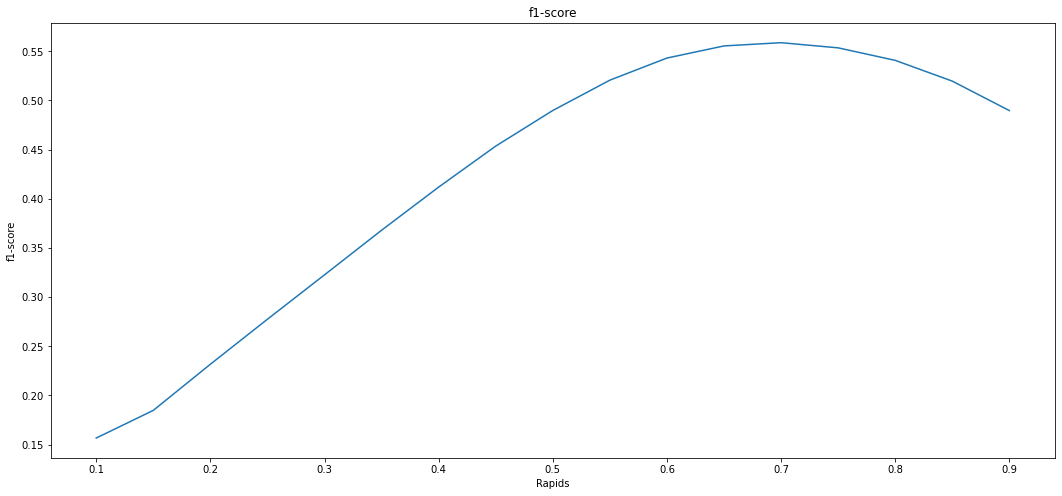

              precision    recall  f1-score   support

           0       0.98      0.96      0.97   1225312
           1       0.49      0.65      0.56     80810

    accuracy                           0.94   1306122
   macro avg       0.73      0.80      0.76   1306122
weighted avg       0.95      0.94      0.94   1306122



In [46]:
plot_f1(df['target'].values, pred1)

In [83]:
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', alpha=1e-7, average=100, l1_ratio=0.1, n_jobs=-1, random_state=42, class_weight='balanced')
model = Pipeline([('vect', vect), ('clf', clf)])

In [39]:
%%time
pred2 = cross_val_predict(model, df.question_text.values, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=1,
                          method='predict_proba')[:, 1]

Wall time: 6min 36s


ROC-AUC score: 0.8807824083274994
 Best rapids for f1-score: 0.9000000000000002
 f1-score: 0.5592874356187686


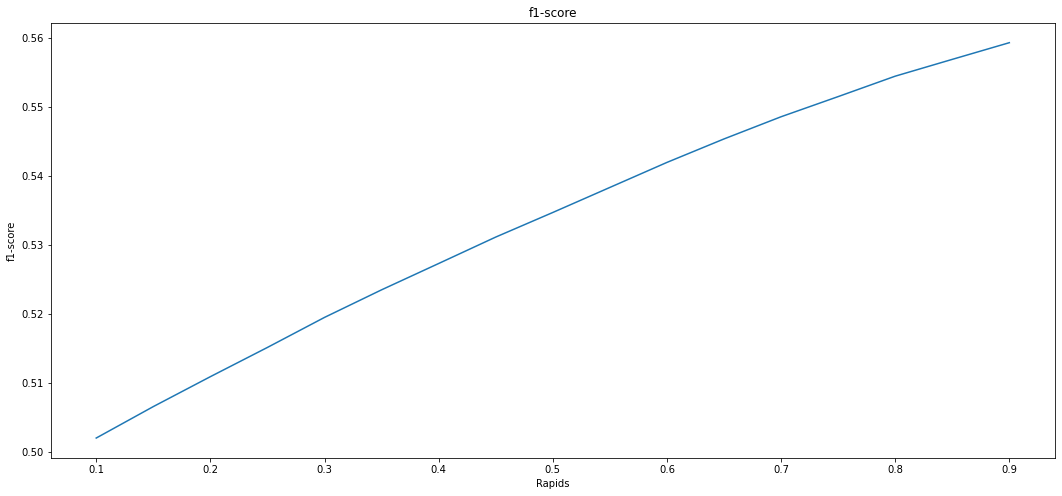

              precision    recall  f1-score   support

           0       0.98      0.94      0.96   1225312
           1       0.45      0.73      0.56     80810

    accuracy                           0.93   1306122
   macro avg       0.72      0.84      0.76   1306122
weighted avg       0.95      0.93      0.94   1306122



In [43]:
plot_f1(df['target'].values, pred2)

# Часть 1.4 Объяснение предсказаний при помощи eli5

Используйте функционал eli5, чтобы посмотреть, как работает ваша модель, сделайте выводы. Для этого прочтите соответствующий туториал на странице https://eli5.readthedocs.io/en/latest/tutorials/sklearn-text.html 

Тем, кто больше любит видосы, можно посмотреть выступление от одного из авторов библиотеки https://www.youtube.com/watch?v=9vYkwD0feb4

Спрашивать буду обязательно, так что разобраться придется. Необходимо вспомнить, что означают веса линейных моделей и как с их помощью объяснять предсказания.

Eli5 предоставляет два способа понять модели машинного обучения:

Это позволяет нам анализировать веса модели, чтобы понять общую производительность модели.
Это позволяет нам анализировать прогнозы отдельных выборок, чтобы понять локальные характеристики модели. Это может помочь нам глубже понять, почему был сделан конкретный прогноз и какие параметры сыграли роль в этом прогнозе.
Eli5 делит свой API на две части, где он может принимать модель в качестве входных данных и генерировать объект Explanation. Затем этот объект можно отформатировать по-разному с помощью различных методов форматирования для форматирования вывода различными способами, такими как HTML, изображение, текст, dict, dataframe и т.д.

Eli5 также может обрабатывать модели sklearn, которые являются конвейером оценщиков, и может выполнять обратное кодирование, выполняемое для данных. Он даже может обрабатывать текст, чтобы показать нам, какая часть текста способствует прогнозированию конкретной метки и данных изображения, чтобы выделить, какая часть изображения использовалась для прогнозирования. Eli5 также обеспечивает реализацию LIME (локально подходящие простые, интерпретируемые независимые от модели объяснения) для довольно сложных оценщиков, и eli5 не имеет методов, которые могли бы объяснить такие модели. 

In [15]:
import eli5.formatters.as_dataframe as eli_df
import eli5

In [17]:
model.fit(df['question_text'], df['target'])

ValueError: too many values to unpack (expected 2)

In [18]:
vect_ex = TfidfVectorizer(stop_words='english')
clf_ex = SGDClassifier(loss='modified_huber', penalty='elasticnet', n_jobs=-1, random_state=42, class_weight='balanced')
model_ex = Pipeline([('vect', vect_ex), ('clf', clf_ex)])

In [80]:
model_ex.fit(df['question_text'], df['target'])

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('clf',
                 SGDClassifier(class_weight='balanced', loss='modified_huber',
                               n_jobs=-1, penalty='elasticnet',
                               random_state=42))])

In [66]:
eli5.show_weights(clf, vec=vect, top=30,
                  target_names=df['target'])

Weight?,Feature
+27.737,castrated
+24.422,castrate
+24.157,castration
+21.456,holoprosencephaly
+20.672,horlaxen
+20.373,futurewins
+19.933,castrating
+19.369,scumbags
+19.023,careongo
+18.976,drumpf


In [81]:
eli5.show_weights(clf_ex, vec=vect_ex, top=30,
                  target_names=df['target'])

Weight?,Feature
+2.780,castrated
+2.748,liberals
+2.733,trump
+2.611,muslims
+2.572,indians
+2.529,democrats
+2.469,women
+2.457,castrate
+2.453,americans
+2.324,jews


In [64]:
eli_df.explain_weights_df(model, vec=vect, top=30, target_names=df['target'])

,target,feature,weight
0,1,castrated,27.736594
1,1,castrate,24.421765
2,1,castration,24.156590
3,1,holoprosencephaly,21.456471
4,1,horlaxen,20.671978
5,1,futurewins,20.372937
6,1,castrating,19.933126
7,1,scumbags,19.368675
8,1,careongo,19.023256
9,1,drumpf,18.976437


In [82]:
eli_df.explain_weights_df(model_ex, vec=vect_ex, top=30, target_names=df['target'])

,target,feature,weight
0,1,castrated,2.779753
1,1,liberals,2.748161
2,1,trump,2.732846
3,1,muslims,2.610773
4,1,indians,2.571833
5,1,democrats,2.528502
6,1,women,2.468513
7,1,castrate,2.456711
8,1,americans,2.453434
9,1,jews,2.323673


In [56]:
eli5.show_prediction(clf, df['question_text'][228], vec=vect, target_names=df['target'])

In [57]:
eli_df.explain_prediction_df(clf, df['question_text'][228], vec=vect, target_names=df['target'])

,target,feature,weight,value
0,0,<BIAS>,7.061682,1.000000
1,0,orc,0.519823,0.627773
2,0,use,0.151221,0.265860
3,0,avro,-0.125913,0.675364
4,0,better,-0.461129,0.281254


In [85]:
eli5.show_prediction(clf_ex, df['question_text'][228], vec=vect_ex, target_names=df['target'])

In [86]:
eli_df.explain_prediction_df(clf_ex, df['question_text'][228], vec=vect_ex, target_names=df['target'])

,target,feature,weight,value
0,0,<BIAS>,0.602594,1.000000
1,0,use,0.062218,0.265860
2,0,better,0.006422,0.281254


In [58]:
eli5.show_prediction(clf, df['question_text'][666], vec=vect, target_names=df['target'])

In [59]:
eli_df.explain_prediction_df(clf, df['question_text'][666], vec=vect, target_names=df['target'])

,target,feature,weight,value
0,0,<BIAS>,7.061682,1.000000
1,0,books,1.579464,0.303000
2,0,best,1.407887,0.196492
3,0,tells,0.393815,0.416312
4,0,political,-0.128326,0.334137
5,0,read,-0.189440,0.313954
6,0,matter,-0.437461,0.353921
7,0,politics,-0.581412,0.372047
8,0,truth,-1.395180,0.385132
9,0,indian,-2.315171,0.272114


In [87]:
eli5.show_prediction(clf_ex, df['question_text'][666], vec=vect_ex, target_names=df['target'])

In [88]:
eli_df.explain_prediction_df(clf_ex, df['question_text'][666], vec=vect_ex, target_names=df['target'])

,target,feature,weight,value
0,0,<BIAS>,0.602594,1.000000
1,0,books,0.221983,0.303000
2,0,best,0.193653,0.196492
3,0,read,0.039808,0.313954
4,0,tells,0.004158,0.416312
5,0,matter,-0.035506,0.353921
6,0,politics,-0.094662,0.372047
7,0,political,-0.111199,0.334137
8,0,truth,-0.235734,0.385132
9,0,indian,-0.355033,0.272114


In [60]:
eli5.show_prediction(clf, df['question_text'][111], vec=vect, target_names=df['target'])

In [61]:
eli_df.explain_prediction_df(clf, df['question_text'][111], vec=vect, target_names=df['target'])

,target,feature,weight,value
0,0,<BIAS>,7.061682,1.000000
1,0,thrice,2.434429,0.621196
2,0,number,1.146821,0.351728
3,0,added,-0.108006,0.471737
4,0,rational,-1.432470,0.517559


In [89]:
eli5.show_prediction(clf_ex, df['question_text'][111], vec=vect_ex, target_names=df['target'])

In [90]:
eli_df.explain_prediction_df(clf_ex, df['question_text'][111], vec=vect_ex, target_names=df['target'])

,target,feature,weight,value
0,0,<BIAS>,0.602594,1.000000
1,0,number,0.123072,0.351728
2,0,rational,-0.078087,0.517559


Выше можно видеть, на основе чего модель приняла то или иное решение. Как правило, она очень уверена в тех ответах, где максимально много слов вносят позитивный или негативный оттенок в предложение.

# Часть 1.5 Стемминг и лемматизация

Проведите для текстов стемминг и лемматизацию. Поскольку это процесс не быстрый, лучше сохранить предобработанные тексты в отдельный столбец DataFrame. Обучите модель на стеммированных и лемматизированных данных, сравните размер словаря

Лемматизация и стемминг – это частные случаи нормализации и они отличаются.

Стемминг – это грубый эвристический процесс, который отрезает «лишнее» от корня слов, часто это приводит к потере словообразовательных суффиксов.

Лемматизация – это более тонкий процесс, который использует словарь и морфологический анализ, чтобы в итоге привести слово к его канонической форме – лемме.

Отличие в том, что стемминг действует без знания контекста и, соответственно, не понимает разницу между словами, которые имеют разный смысл в зависимости от части речи. Однако у стеммеров есть и свои преимущества: их проще внедрить и они работают быстрее. Плюс, более низкая «аккуратность» может не иметь значения в некоторых случаях.

Примеры:
Слово good – это лемма для слова better. Стеммер не увидит эту связь, так как здесь нужно сверяться со словарем.
Слово play – это базовая форма слова playing. Тут справятся и стемминг, и лемматизация.
Слово meeting может быть как нормальной формой существительного, так и формой глагола to meet, в зависимости от контекста. В отличие от стемминга, лемматизация попробует выбрать правильную лемму, опираясь на контекст.

In [18]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer, LancasterStemmer

In [19]:
from functools import lru_cache

In [21]:
# эта вспомогательная функция поможет вам чуть быстрее пройтись по всему тексту
# обратите внимание, что лемматизация будет в основном работать только для слов в нижнем регистре!

LEMMATIZER = WordNetLemmatizer()

@lru_cache(maxsize=2048)
def lemmatize_word(word):
    parts = ['a','v','n','r']
    for part in parts:
        temp = LEMMATIZER.lemmatize(word, part)
        if temp != word:
            return temp
    return word    

In [20]:
stemmer = SnowballStemmer('english')

In [23]:
print(lemmatize_word('having'))
print(stemmer.stem('having'))

have
have


In [24]:
print(stemmer.stem('tolerant'))
print(stemmer.stem('tolerable'))

toler
toler


In [22]:
tokenized = [sklearn_tokenizer(text) for text in df['question_text']]

In [23]:
def lemmatize_data(tokenized):
    for text in tokenized:
        lemmatized_words_list = [lemmatize_word(word.lower()) for word in text]
        yield ' '.join(lemmatized_words_list)

In [24]:
def stemming_data(tokenized):
    for text in tokenized:
        stem_words_list = [stemmer.stem(word.lower()) for word in text]
        yield ' '.join(stem_words_list)

In [25]:
lemmatized = list(lemmatize_data(tokenized))
stemmed = list(stemming_data(tokenized))

In [101]:
lemmatized;

In [26]:
df['lemmatized_text'] = lemmatized
df['stemmed_text'] = stemmed

In [103]:
df.to_csv('train_model.csv', index=False)

In [30]:
df.loc[0:10, ['question_text', 'lemmatized_text', 'stemmed_text']].values

array([['How did Quebec nationalists see their province as a nation in the 1960s?',
        'how do quebec nationalist see their province a nation in the 1960s',
        'how did quebec nationalist see their provinc as nation in the 1960s'],
       ['Do you have an adopted dog, how would you encourage people to adopt and not shop?',
        'do you have an adopt dog how would you encourage people to adopt and not shop',
        'do you have an adopt dog how would you encourag peopl to adopt and not shop'],
       ['Why does velocity affect time? Does velocity affect space geometry?',
        'why do velocity affect time do velocity affect space geometry',
        'whi doe veloc affect time doe veloc affect space geometri'],
       ['How did Otto von Guericke used the Magdeburg hemispheres?',
        'how do otto von guericke use the magdeburg hemisphere',
        'how did otto von guerick use the magdeburg hemispher'],
       ['Can I convert montra helicon D to a mountain bike by just 

In [27]:
vect_lem = TfidfVectorizer(stop_words='english').fit(df['lemmatized_text'])
vect_stem = TfidfVectorizer(stop_words='english').fit(df['stemmed_text'])

In [107]:
len(vect_lem.get_feature_names())

172041

In [108]:
len(vect_stem.get_feature_names())

153163

In [32]:
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', alpha=1e-7, average=100, l1_ratio=0.1,
                     n_jobs=-1, random_state=42, class_weight='balanced')
model = Pipeline([('vect', vect), ('clf', clf)])

In [110]:
%%time
pred = cross_val_predict(model, df['lemmatized_text'].values, df['target'].values,
                          cv=StratifiedKFold(5), n_jobs=-1, 
                          method='predict_proba')[:, 1]

Wall time: 5min 16s


ROC-AUC score: 0.8837701565576938
 Best rapids for f1-score: 0.9000000000000002
 f1-score: 0.5470304505807302


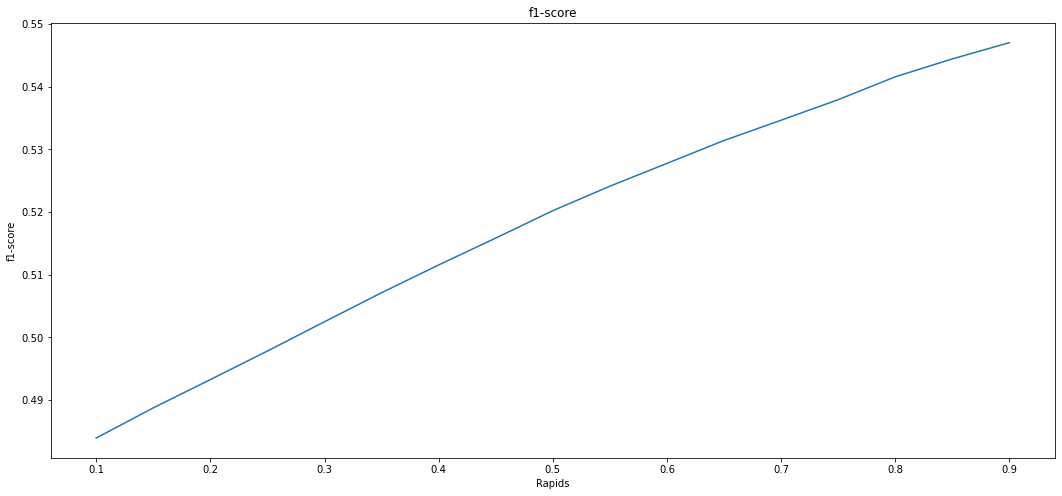

              precision    recall  f1-score   support

           0       0.98      0.94      0.96   1225312
           1       0.43      0.74      0.55     80810

    accuracy                           0.92   1306122
   macro avg       0.71      0.84      0.75   1306122
weighted avg       0.95      0.92      0.93   1306122



In [111]:
plot_f1(df['target'].values, pred)

In [112]:
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', alpha=1e-7, average=100, l1_ratio=0.1,
                     n_jobs=-1, random_state=42, class_weight='balanced')
model = Pipeline([('vect', vect), ('clf', clf)])

In [113]:
%%time
pred3 = cross_val_predict(model, df.stemmed_text.values, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=-1, 
                          method='predict_proba')[:, 1]

Wall time: 4min 2s


ROC-AUC score: 0.8879092014619137
 Best rapids for f1-score: 0.9000000000000002
 f1-score: 0.5593525429532592


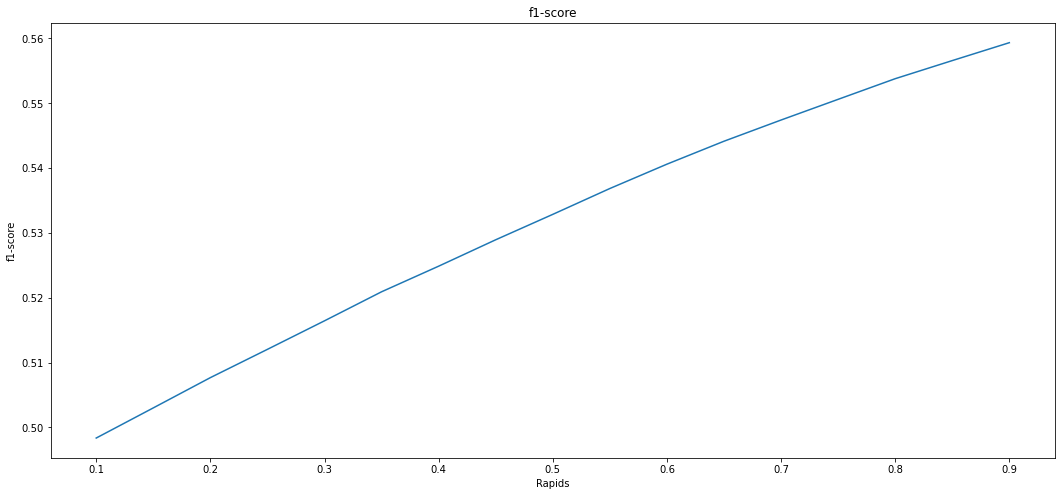

              precision    recall  f1-score   support

           0       0.98      0.94      0.96   1225312
           1       0.45      0.75      0.56     80810

    accuracy                           0.93   1306122
   macro avg       0.71      0.84      0.76   1306122
weighted avg       0.95      0.93      0.94   1306122



In [114]:
plot_f1(df['target'].values, pred3)

# Часть 1.6 Оптимизация модели

Подберите с помощью GridSearch или RandomizedSearch хорошие параметры вашей модели. Когда вы делаете сетку для пайплайна параметры надо называть так как у внутреннего класса, добавляя названия соответствующего этапа перед ними. Например:

In [115]:
grid = {'clf__l1_ration': [0.1, 0.5],
        'vect__lowercase': [True, False]
        }

Попробуйте разные функции ошибок для SGD. Например hinge (внутри получится svm, нельзя будет предсказывать вероятности), modified_huber - комбинация l1 и l2 ошибки для классификации (упоминалась на одной из прошлых лекций). 
Разную предобработку, параметры, подберите порог принятия решения.

Попробуйте уменьшать размер словаря путем комбинации лемматизации (или стемминга) и увеличения min_df. Проанализируйте, как меняется размер словаря, а также качество модели.

In [116]:
param_grid = {
    'clf__loss': ['modified_huber', 'hinge'],
    'vect__min_df': [25, 50],
    'vect__vocabulary': [vect_lem.get_feature_names(), vect_stem.get_feature_names()]
}

In [117]:
vect = TfidfVectorizer(stop_words='english', lowercase=True)
clf = SGDClassifier(penalty='elasticnet', n_jobs=-1, random_state=42, l1_ratio=0.1, alpha=1e-7, class_weight='balanced', average=10)
model = Pipeline([('vect', vect), ('clf', clf)])
estimator = RandomizedSearchCV(model, param_grid, scoring=f1_make_scorer, n_jobs=-1, n_iter=5, cv=StratifiedKFold(5), random_state=42, verbose=1)

In [118]:
%%time
estimator.fit(df['question_text'].values, df['target'].values)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Wall time: 15min 4s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words='english')),
                                             ('clf',
                                              SGDClassifier(alpha=1e-07,
                                                            average=10,
                                                            class_weight='balanced',
                                                            l1_ratio=0.1,
                                                            n_jobs=-1,
                                                            penalty='elasticnet',
                                                            random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'clf__loss': ['modified_...
                                                              '0000000000000

In [119]:
estimator.best_params_['vect__vocabulary'] == vect_lem.get_feature_names()

True

In [121]:
vect = TfidfVectorizer(stop_words='english', lowercase=True, min_df=25, vocabulary=vect_lem.get_feature_names())
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', shuffle=True, n_jobs=-1, random_state=42, l1_ratio=0.1, alpha=1e-7,
                    class_weight='balanced', average=10)
model = Pipeline([('vect', vect), ('clf', clf)])

In [122]:
pred5 = cross_val_predict(model, df['question_text'].values, df['target'].values,
                          cv=StratifiedKFold(5), n_jobs=-1, 
                          method='predict_proba')[:, 1]

ROC-AUC score: 0.8477400668947378
 Best rapids for f1-score: 0.9000000000000002
 f1-score: 0.4440137553016897


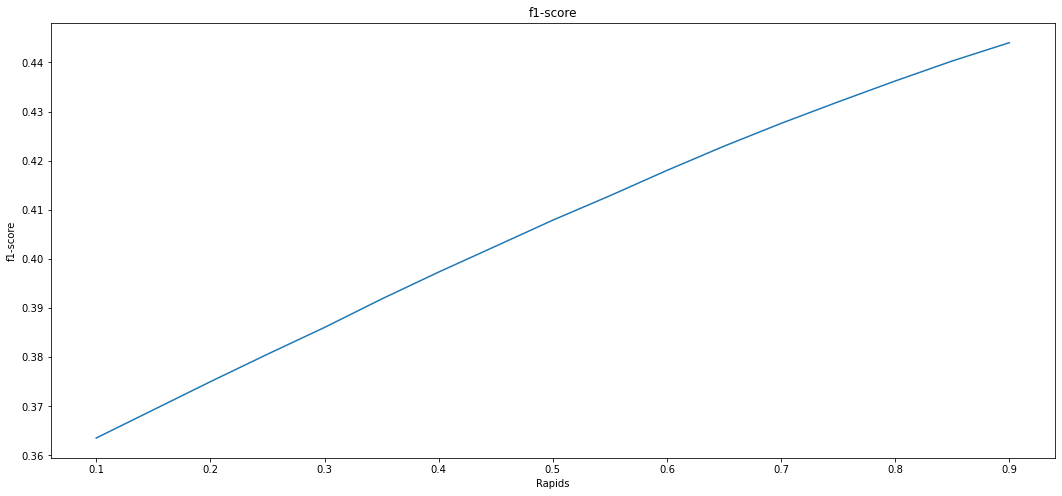

              precision    recall  f1-score   support

           0       0.98      0.91      0.94   1225312
           1       0.33      0.68      0.44     80810

    accuracy                           0.89   1306122
   macro avg       0.65      0.80      0.69   1306122
weighted avg       0.94      0.89      0.91   1306122



In [123]:
plot_f1(df['target'].values, pred5)

# Часть 2 (На 10). Тематическое моделирование

Используйте либо https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html, либо модели из gensim (https://radimrehurek.com/gensim/models/ldamodel.html) для тематического моделирования на этих текстах. Посмотрите на полученные темы, попытайтесь их интерпретировать. Используйте распределение тем для документа в качестве набора признаков, описывающих его. Обучите модель на этих признаках и сравните с tf-idf.

Поскольку задание на 10 тут не будет никакой дополнительной информацию. Те, кто делают, пусть пишут мне сообщения и задают вопросы на паре. Отвечу и помогу точечно.

# Часть 3. word2vec

В этой части вам надо будет пощупать вектора слов, поискать ассоциации, а потом использовать эти вектора как признаки для вашей модели.


Скачайте векторы отсюда и загрузите их при помощи кода ниже.

https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download


Если ваш компьютер не позволяет загрузить большие векторы, воспользуйтесь векторами вот отсюда. Они будут в 10 раз меньше по размеру.

https://github.com/eyaler/word2vec-slim/blob/master/GoogleNews-vectors-negative300-SLIM.bin.gz

Для работы с большими векторами нужно как минимум 8 гб оперативной памяти. Если у вас их нет, то пользуйтесь маленькими, либо google colaboratory, либо kaggle kernels.

In [132]:
%pip install smart_open

In [135]:
%pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


In [28]:
import smart_open
smart_open.open = smart_open.smart_open
from gensim.models import KeyedVectors

In [29]:
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Задание 3.1 Знакомство с векторами

Пощупайте векторы и найдите по крайней мере 2 **семантических** и 2 **синтаксических** аналогии

Семантика ~ Значение
Синтаксис ~ Символическое представление

Синтаксис - это структура или грамматика языка. Он отвечает на вопрос: как мне построить правильное предложение? Все языки, даже английский и другие человеческие (он же "natural") языки, имеют грамматики, то есть правила, которые определяют, правильно ли построено предложение.
Семантика-это значение предложения. Он отвечает на вопросы: является ли это предложение действительным? Если да, то что означает это предложение?

In [35]:
# вот так можно получить вектор слова
w2v['Minsk']

array([ 9.32617188e-02,  2.24609375e-02,  1.91406250e-01,  5.42968750e-01,
        1.27929688e-01, -4.15039062e-02,  6.10351562e-02, -7.59887695e-03,
       -4.62890625e-01, -1.47094727e-02, -2.03125000e-01,  3.04687500e-01,
        3.24707031e-02,  1.51367188e-01,  7.91015625e-02,  4.93164062e-02,
       -2.42187500e-01, -4.98046875e-02, -9.57031250e-02, -1.72851562e-01,
        2.87109375e-01, -2.39257812e-01,  1.46484375e-02, -4.71191406e-02,
        1.31835938e-01, -4.04357910e-04, -2.59765625e-01, -7.22656250e-02,
       -3.33984375e-01,  7.66601562e-02, -3.41796875e-01, -1.41601562e-01,
       -1.53320312e-01,  8.25195312e-02,  1.68945312e-01,  8.64257812e-02,
       -3.43750000e-01,  2.19726562e-01, -7.72094727e-03, -3.49609375e-01,
        1.23535156e-01,  3.75976562e-02,  3.08593750e-01, -1.22558594e-01,
       -1.77001953e-03, -4.98046875e-02,  3.41796875e-02, -4.76074219e-02,
       -1.66992188e-01,  2.22656250e-01, -2.44140625e-02, -5.00488281e-03,
        3.20374966e-06,  

Вот так работают аналогии

Использование sentence embeddings: модели типа word2vec или sent2vec. Пример их использования — "король" + "женщина" — "мужчина" = "королева". Если коротко, то суть в том, чтобы перевести слова (предложения, тексты) в векторное пространство с сохранением семантического расстояния между ними. Такой подход открывает перед нами замечательные возможности по оценке близости текстов и их кусочков по смыслу.

In [5]:
# vec(Minsk) - vec(Belarus) + vec(Russia) ~= vec(Moscow)
w2v.most_similar(positive=['Minsk', 'Russia'], negative=['Belarus'])

[('Moscow', 0.7905825972557068),
 ('Tbilisi', 0.6598107218742371),
 ('Kyiv', 0.6513273119926453),
 ('Kremlin', 0.6477817893028259),
 ('Kiev', 0.6403970122337341),
 ('Saint_Petersburg', 0.635554850101471),
 ('St_Petersburg', 0.6216074824333191),
 ('Baku', 0.618080198764801),
 ('Vilnius', 0.6057642698287964),
 ('Putin', 0.5993437170982361)]

In [16]:
# семантические
w2v.most_similar(positive=['killer', 'queen'], negative=['king'])

[('killers', 0.5804442167282104),
 ('murderer', 0.5400042533874512),
 ('serial_killer', 0.5138161182403564),
 ('rapist', 0.5040439367294312),
 ('murderess', 0.48673558235168457),
 ('Killer', 0.4715416729450226),
 ('serial_rapist', 0.45778417587280273),
 ('serial_killers', 0.4479433298110962),
 ('kidnapper', 0.4435330629348755),
 ('Moors_Murderers', 0.4369093179702759)]

In [10]:
w2v.most_similar(positive=['policeman', 'man'], negative=['woman'])

[('cop', 0.5956324338912964),
 ('Policeman', 0.5897844433784485),
 ('policemen', 0.5555378794670105),
 ('taxi_driver', 0.5446732044219971),
 ('constable', 0.5369301438331604),
 ('patrolman', 0.5226218104362488),
 ('sergeant', 0.5130869150161743),
 ('soldier', 0.5074026584625244),
 ('askari', 0.5033218860626221),
 ('taximan', 0.4899348020553589)]

In [15]:
# синтаксические
w2v.most_similar(positive=['driving', 'travel'], negative=['drive'])

[('traveling', 0.6640777587890625),
 ('Travel', 0.53085857629776),
 ('Travelling', 0.4479776918888092),
 ('travelers', 0.4444577693939209),
 ('Driving', 0.43843552470207214),
 ('Traveling', 0.4224492907524109),
 ('travels', 0.4080311357975006),
 ('commuting', 0.39884302020072937),
 ('rebooking_flights', 0.39883700013160706),
 ('traveled', 0.39638522267341614)]

In [14]:
w2v.most_similar(positive=['having', 'has'], negative=['have'])

[('being', 0.443345844745636),
 ('Having', 0.42734086513519287),
 ('had', 0.40827712416648865),
 ('was', 0.40694287419319153),
 ('hasbeen', 0.4012598693370819),
 ('admitting', 0.38245365023612976),
 ('is', 0.3807489275932312),
 ('Has', 0.3645123839378357),
 ('maintains', 0.36306387186050415),
 ('feels', 0.35612162947654724)]

# Задание 3.2 Использование среднего вектора в качестве фичей для моделирования

Как мы и говорили на лекции, вектора слов можно использовать для построения признакового описания текста путем усреднения векторов. Сделайте это. Для этого нужно:
1. Токенизировать каждый текст
2. Для каждого токена попробовать найти вектор в w2v. Если его там нет, то просто игнорировать.
3. Усреднить все вектора слов текста для получения его признакового описания. Если ни одного из слов в тексте нет вектора, то вернуть вектор из нулей той же длины

На полученных признаках обучите модель для предсказания и сравните качество.

ВНИМАНИЕ! Не забывайте нормировать вектора с помощью numpy!



In [30]:
def get_w2v_vect(token, w2v):
    token = token.lower()
    if token in w2v.index_to_key:
        return w2v[token]
    else:
        return np.zeros(w2v.vector_size) 

In [31]:
def get_features_from_text(tokenized_sent, w2v):
    vect = np.array([get_w2v_vect(token, w2v) for token in tokenized_sent]).mean(axis=0) 
    vect_norm = np.linalg.norm(vect)
    if vect_norm != 0:
        return vect/vect_norm
    else:
        return vect

In [ ]:
w2v_data = np.array([get_features_from_text(tokenized_sent, w2v) 
                    for tokenized_sent in tokenized[::5]])

In [ ]:
y = df['target'][::5]

In [ ]:
y

In [ ]:
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', l1_ratio=0.1, alpha=1e-6, class_weight='balanced', random_state=42)

In [ ]:
pred10 = cross_val_predict(clf, w2v_data, y, cv=StratifiedKFold(5), n_jobs=-1, method='predict_proba')[:, 1]

In [ ]:
plot_f1(y, pred10)

На признаках текстов, полученных из word2vec не получилось особо повысить качество классификации.

# Часть 4 (На 9). Давайте используем Transformers как полностью черный ящик и сравним качество 

Давайте теперь попробуем взять вектора слов из другого источника. В этом нам поможет библиотека sentence_transformers, которую вам нужно установить следующим образом:
1. conda install -c conda-forge sentence-transformers
2. Если при загрузке модели у вас вываливаются ошибки, в которых что-то говорится о несовместимых версиях файлов, то убедитесь, что вас установился pytorch версии 1.6 или выше с помощью conda list. Обновите, если вдруг это не так. 
3. Если кто-то является счастливым обладателем игровой видеокатры, то пусть выполняет эти вычисления на gpu. Остальным рекомендую или считать на kaggle kernels/google colaboratory, или сэмплировать данные, чтобы их было меньше.


Документация к библиотеке вот тут: https://www.sbert.net/docs/quickstart.html

Модели, которые мы будем использовать, являются не только мультиязыковыми, но и выровненными, это означает, что, если им на вход подавать предложения на разных языках, то вектора все равно будут сохранять между собой семантическое расстояние, — вектор для "I love cats" будет близок вектору "Я люблю кошек". 

Использование sentence embeddings: модели типа word2vec или sent2vec. Пример их использования — "король" + "женщина" — "мужчина" = "королева". Если коротко, то суть в том, чтобы перевести слова (предложения, тексты) в векторное пространство с сохранением семантического расстояния между ними. Такой подход открывает перед нами замечательные возможности по оценке близости текстов и их кусочков по смыслу.


In [1]:
%pip install sentence-transformers

  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=a2c7edd51a0390968214fd8630c4cf51b481b216f0d9d003abd3cb0b38aec51c
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\52\19\88\6625593382e23a926740e6fcee0f2df0a0de25766094842a28
Successfully built sentence-transformers
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sentence_transformers import SentenceTransformer

В качестве векторизатора возьмем модель, которую авторы библиотеки рекомендуют по умолчанию. Во время первого выполнения ячейки файл с весами модели будет скачан вам на компьютер.

В дальнейшем используйте model.encode, чтобы преобразовать ваши тексты в вектора. Обратите внимание, что токенизация происходит внутри без вашего участия. Вы просто подаете тексты.

В инициализации ниже указана модель all-mpnet-base-v2. Для скорости можно взять модель полегче. Например, all-MiniLM-L6-v2. Список моделей вот тут: https://www.sbert.net/docs/pretrained_models.html 


Если будет выпадать ошибка "ImportError: IProgress not found. Please update jupyter and ipywidgets. See 
https://ipywidgets.readthedocs.io/en/stable/user_install.html", то установите их с помощью **conda install ipywidgets**

In [3]:
model = SentenceTransformer('all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Задания следующие:

- Преобразуйте все тексты в признаки (их должно быть 768 для каждого текста). Обучите SGDClassifer на этих признаках и сравните качество с предыдущими вариантами.

- Попробуйте поискать с помощью модели похожие вопросы как показано в sbert quickstart (ссылка выше).

In [ ]:
%%time
pool = model.start_multi_process_pool(target_devices=['cuda', 'cuda'])
embedding = model.encode_multi_process(df['question_text'].values[::5], pool)

print(embedding.shape)
model.stop_multi_process_pool(pool)

In [ ]:
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', l1_ratio=0.1, alpha=1e-6, class_weight='balanced', random_state=42)

In [ ]:
%%time
pred22 = cross_val_predict(clf, embedding, y, cv=StratifiedKFold(5), n_jobs=-1, method='predict_proba')[:, 1]

In [ ]:
plot_f1(y, pred22)

# Задание 5 (На +1 к лабораторной по кластеризации). Кластеризация текстов на основе векторизации

Возьмите какую-то из векторизаций текстов на выбор и проведите для них кластеризацию способами из прошлой лабы по всем правилам. Попробуйте объяснить найденные кластеры, если они получатся и представить результат преподавателю. Если кластеризация не выходит, то обоснуйте это метриками и графиками.

P.S. Если у вас и так 10 за кластеризацию, то плюс можно будет добавить к любой лабе. Если у вас 10 за все лабы, то я вами горжусь!

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_score
import matplotlib.cm as cm

In [ ]:
def hopkins_statistic(X, m_fraction=1):
    d = X.shape[1]
    n = X.shape[0]
    m = int(m_fraction * n)
    X_scaled = StandardScaler().fit_transform(X)
    X_sample = X_scaled[np.random.choice(range(0, n), m, replace=False)]
    neighbors = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(X_scaled)
    Y_rand = np.random.uniform(-1, 1, size=(m, d))
    y = []
    x = []
    for j in range(0, m):
        y.append(neighbors.kneighbors(Y_rand[j].reshape(1, -1),
                                      n_neighbors=1,
                                      return_distance=True)[0][0][0])
        x.append(neighbors.kneighbors(X_sample[j].reshape(1, -1),
                                      n_neighbors=2,
                                      return_distance=True)[0][0][1])

    H = sum(y) / (sum(x) + sum(y))
    return 1 - H

In [ ]:
def silhouette_plot(X, n_clusters=2, y_true=None):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    y_pred = clusterer.fit_predict(X)

    sample_silhouette_values = silhouette_samples(X, y_pred)
    silhouette_avg = np.mean(sample_silhouette_values)

    print('For n_clusters =', n_clusters,
        '\nThe average silhouette_score is', silhouette_avg)
        
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    if y_true is not None:
        ax1.set_title(f'The silhouette plot for {n_clusters} clusters.' + 
            f'\n Homogeneity index for MNIST ({n_clusters} clusters): ' +
             f'{round(homogeneity_score(y_true, y_pred), 4)}')
    else:
        ax1.set_title(f'The silhouette plot for {n_clusters} clusters.')

    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster label')

    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(y_pred.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c='white', alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title('The visualization of the clustered data.')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space for the 2nd feature')

    plt.suptitle(('Silhouette analysis for KMeans clustering on sample data '
                  'with n_clusters = %d' % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

1. Чем ближе к 0, тем более выраженная кластерная структура (значение меньше 0.25 означает 90% вероятность наличия кластерной структуры)
2. Чем ближе к 0.5, тем больше данные похожи на шум. Может не очень хорошо работать в пространствах с большой размерностью
3. Если статистика близка к единице, то в данных есть какая-то структура, но не кластерная

In [ ]:
print('Hopkins statistic for w2v:', hopkins_statistic(w2v_data[:1000]))

In [ ]:
silhouette_plot(w2v_data[:1000], 2, y[:1000])

In [ ]:
print('Hopkins statistic for t-SNE:', hopkins_statistic(embeddings[:1000]))

In [ ]:
silhouette_plot(embeddings, 2, y[:1000])

In [ ]:
print("Homogeneity index :",homogeneity_score(y[:1000], embeddings[:1000]))

In [ ]:
print("Homogeneity index :",homogeneity_score(y[:1000], w2v_data[:1000]))